In [1]:
!pip install prophet

## **Import libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# **Load the dataset**

In [3]:
file_path = '/content/sales_data_sample.csv'
sales_data = pd.read_csv(file_path, encoding='latin1')

In [4]:
# first 5 rows
print("First 5 Rows of the Data:")
print(sales_data.head())

# Display all columns
pd.set_option('display.max_columns', None)

# data types and other information
print("\nDataset Info (Data Types and Missing Values):")
print(sales_data.info())

# summary statistics of the dataset
print("\nSample Statistics of the Dataset:")
print(sales_data.describe())

First 5 Rows of the Data:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue

### **Preprocessing**

# Handle Missing Values

In [5]:
sales_data['STATE'] = sales_data['STATE'].fillna('Unknown')
sales_data['POSTALCODE'] = sales_data['POSTALCODE'].fillna('Unknown')

In [6]:
# For numeric columns like 'SALES', we can either drop or impute missing values.
sales_data['SALES'] = sales_data['SALES'].fillna(sales_data['SALES'].mean())

# ORDERDATE to datetime

In [7]:
sales_data['ORDERDATE'] = pd.to_datetime(sales_data['ORDERDATE'], errors='coerce')

# Extract Date-based Features

In [8]:
sales_data['year'] = sales_data['ORDERDATE'].dt.year
sales_data['month'] = sales_data['ORDERDATE'].dt.month
sales_data['day'] = sales_data['ORDERDATE'].dt.day
sales_data['dayofweek'] = sales_data['ORDERDATE'].dt.dayofweek
sales_data['weekofyear'] = sales_data['ORDERDATE'].dt.isocalendar().week
sales_data['quarter'] = sales_data['ORDERDATE'].dt.quarter
sales_data['dayofyear'] = sales_data['ORDERDATE'].dt.dayofyear

# Remove Outliers

In [9]:
Q1 = sales_data['SALES'].quantile(0.25)
Q3 = sales_data['SALES'].quantile(0.75)
IQR = Q3 - Q1
sales_data = sales_data[(sales_data['SALES'] >= (Q1 - 1.5 * IQR)) & (sales_data['SALES'] <= (Q3 + 1.5 * IQR))]

# Rolling Averages

In [10]:
sales_data['7_day_avg'] = sales_data['SALES'].rolling(window=7).mean()
sales_data['30_day_avg'] = sales_data['SALES'].rolling(window=30).mean()


# Drop NaN values


In [11]:
sales_data = sales_data.dropna(subset=['7_day_avg', '30_day_avg'])

# Normalize/Scale the Numeric Features

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sales_data[['SALES', '7_day_avg', '30_day_avg']] = scaler.fit_transform(sales_data[['SALES', '7_day_avg', '30_day_avg']])

# cleaned data

In [13]:
print("\nCleaned and Preprocessed Data:")
print(sales_data.head())


Cleaned and Preprocessed Data:
    ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  \
29        10140               37      100.0               11  2.538501   
31        10163               21      100.0                1  0.940389   
33        10183               23      100.0                8  1.266087   
34        10194               42      100.0               11  2.485266   
36        10215               35      100.0                3  1.712827   

    ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID   PRODUCTLINE  MSRP  \
29 2003-07-24  Shipped       3         7     2003  Classic Cars   214   
31 2003-10-20  Shipped       4        10     2003  Classic Cars   214   
33 2003-11-13  Shipped       4        11     2003  Classic Cars   214   
34 2003-11-25  Shipped       4        11     2003  Classic Cars   214   
36 2004-01-29  Shipped       1         1     2004  Classic Cars   214   

   PRODUCTCODE                 CUSTOMERNAME       PHONE        ADDRESSLINE1  \
29   

# Prophet Model for Time Series Forecasting

In [14]:
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(sales_data[['ORDERDATE', 'SALES']].rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm9ky5pr5/rfpu2wul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm9ky5pr5/lfdwn06q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37184', 'data', 'file=/tmp/tmpm9ky5pr5/rfpu2wul.json', 'init=/tmp/tmpm9ky5pr5/lfdwn06q.json', 'output', 'file=/tmp/tmpm9ky5pr5/prophet_modelh8_r05is/prophet_model-20250426131037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Forecasting Future Sales

In [17]:
future = model_prophet.make_future_dataframe(periods=90, freq='D')
forecast = model_prophet.predict(future)

# Plot Forecast

<Figure size 1000x600 with 0 Axes>

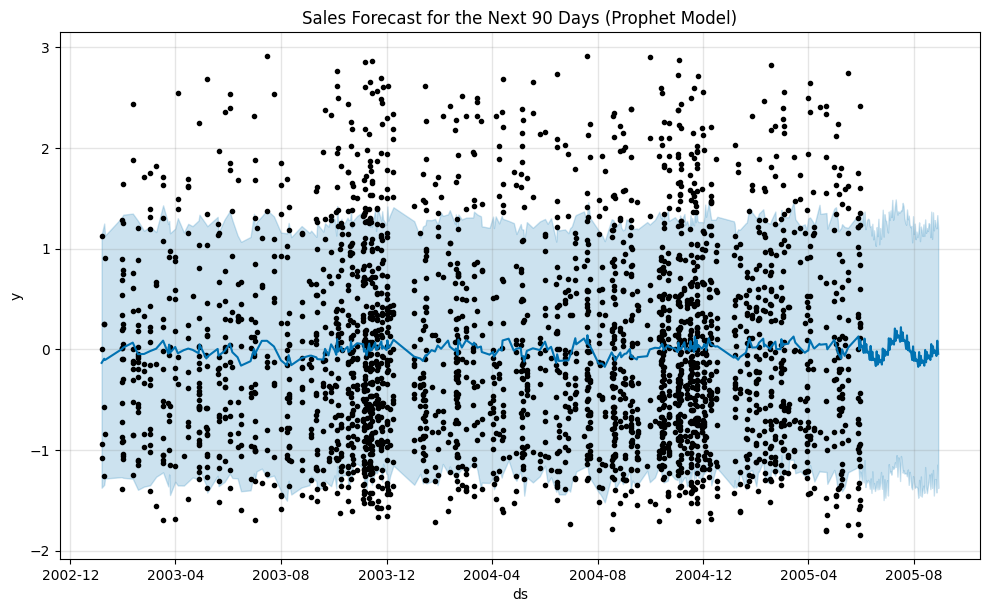

In [18]:
plt.figure(figsize=(10, 6))
model_prophet.plot(forecast)
plt.title('Sales Forecast for the Next 90 Days (Prophet Model)')
plt.grid(True)
plt.show()

# Plot the Prophet Forecast Components

<Figure size 1000x600 with 0 Axes>

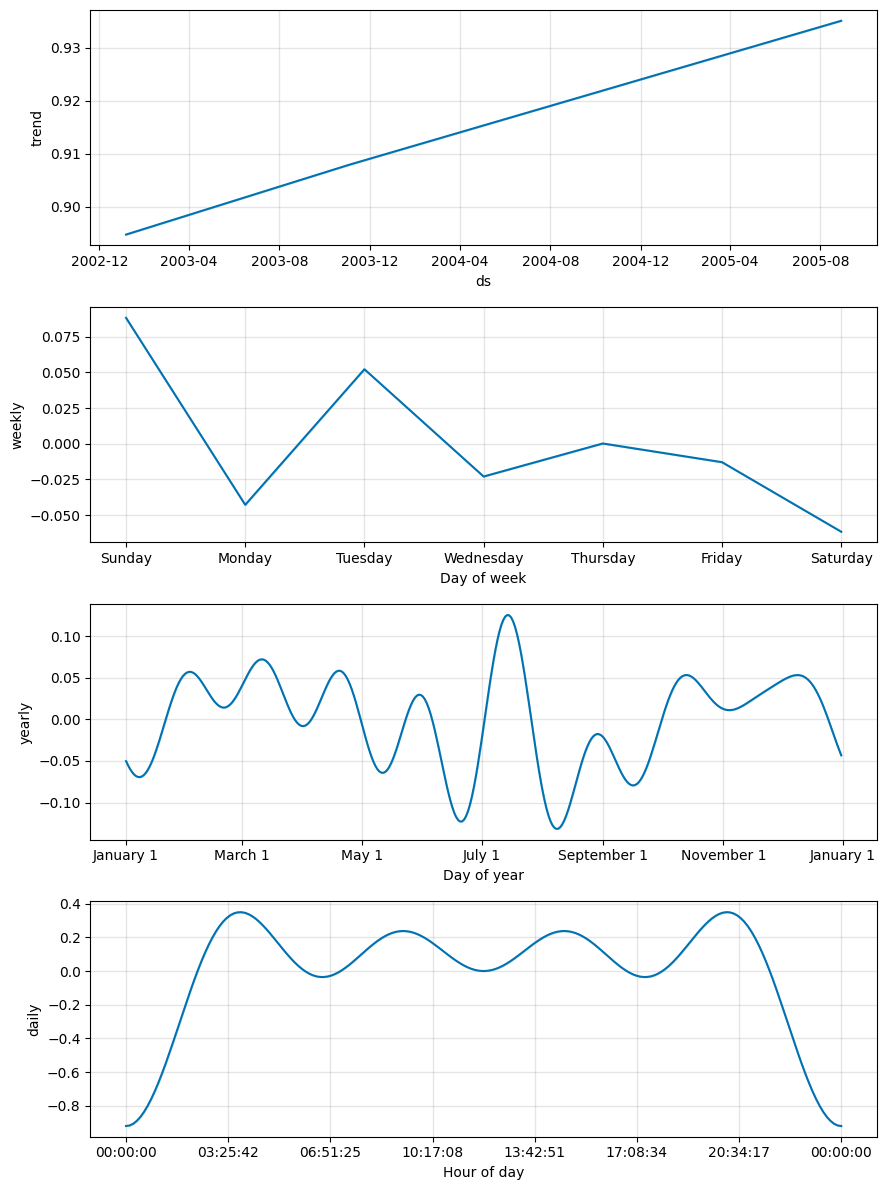

In [19]:
plt.figure(figsize=(10, 6))
model_prophet.plot_components(forecast)
plt.show()

# Random Forest Regressor for Sales Prediction

In [20]:
sales_data['year'] = sales_data['ORDERDATE'].dt.year
sales_data['month'] = sales_data['ORDERDATE'].dt.month
sales_data['day'] = sales_data['ORDERDATE'].dt.day
sales_data['dayofweek'] = sales_data['ORDERDATE'].dt.dayofweek

# Feature selection and target (sales)

In [21]:
X = sales_data[['year', 'month', 'day', 'dayofweek', '7_day_avg', '30_day_avg']]
y = sales_data['SALES']

# Train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor

In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Predict and Evaluate Random Forest Model

In [24]:
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics

In [25]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [26]:
print(f"Random Forest Model Evaluation:\nMSE: {mse:.2f}\nR2 Score: {r2:.2f}")

Random Forest Model Evaluation:
MSE: 0.64
R2 Score: 0.39


# **Plot Actual vs Predicted Sales**

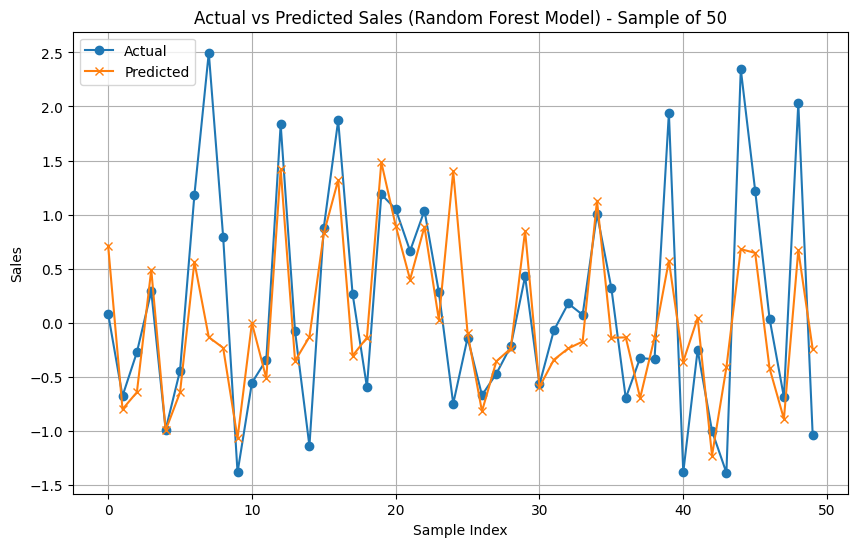

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales (Random Forest Model) - Sample of 50')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()